# Proof of concept: the Two-SNP example

Here I pick up a particular data-set and make a very specific simulation case:

1. In data I find SNPs with -0.8 correlations
2. I then simulate for one SNP to be associated with 3 phenotypes, and the other to be associated with the rest, both with fixed positive effect size

[See here](https://github.com/stephenslab/gtexresults/blob/master/workflows/2SNP.ipynb) for motivation of the analysis.

In [1]:
%cd /home/gaow/tmp/13-May-2019

/home/gaow/Documents/TempDir/13-May-2019

## Find negatively correlation SNPs

In [2]:
genotype = readRDS('Multi_Tissues.ENSG00000089486.RDS')$X

In [3]:
ld = cor(genotype)

From MASH paper the variants in question are:

```
"4","ENSG00000089486.12","16_4525265_C_T_b37","16_4594671_C_T_b37"
```

Let's check them out. First [liftOver here](https://genome.ucsc.edu/cgi-bin/hgLiftOver)

```
chr16:4525264-4525265
chr16:4594670-4594671
```
to
```
chr16:4475263-4475264
chr16:4544669-4544670
```

which is `chr16_4475264_C_T_b38` and `chr16_4544670_C_T_b38`

In [4]:
ld["chr16_4475264_C_T_b38", "chr16_4544670_C_T_b38"]

[1] -0.7341668

In [5]:
snp1 = which(rownames(ld) == "chr16_4475264_C_T_b38")

In [6]:
snp2 = which(rownames(ld) == "chr16_4544670_C_T_b38")

In [7]:
apply(genotype,2,sum)[snp1] / nrow(genotype) / 2

chr16_4475264_C_T_b38 
            0.7195704

In [8]:
apply(genotype,2,sum)[snp2] / nrow(genotype) / 2

chr16_4544670_C_T_b38 
            0.3562053

## Simulate multivariate phenotypes

In [9]:
P = ncol(genotype)
R = 6
eff_factor = 1.2

In [10]:
set.seed(1)
b = matrix(0, P, R)
sharing = matrix(0.75, 3, 3)
diag(sharing) = 1

In [11]:
b[snp1, 1:3] = abs(MASS::mvrnorm(1, rep(0,3), sharing)) / eff_factor
b[snp2, 4:6] = abs(MASS::mvrnorm(1, rep(0,3), sharing)) / eff_factor
print(b[snp1, 1:3])
print(b[snp2, 4:6])

[1] 0.2439935 0.4412627 0.7444224
[1] 1.4208123 1.2987575 0.9211438


In [12]:
g = genotype %*% b

In [13]:
apply(g,2,sd) * eff_factor

[1] 0.1867193 0.3376821 0.5696791 1.1928434 1.0903722 0.7733465

In [14]:
e = MASS::mvrnorm(1, rep(0,R), diag(R) * 1)

In [15]:
Y = g + e

## Prepare MASH mixture prior

In [38]:
U1 = matrix(0,R,R)
U1[1:3,1:3] = sharing
U2 = matrix(0,R,R)
U2[4:6,4:6] = sharing
Ulist = list(U1=U1, U2=U2)
scaling = c(0.5,1) / eff_factor
mash_init = mmbr:::MashInitializer$new(Ulist, scaling, alpha = 0)

## Fit MV-SuSiE

In [39]:
res = mmbr::susie(genotype,Y,
                  L=10,V=mash_init,
                  compute_objective=FALSE, precompute_covariances=F)

In [40]:
snps = sub("_[A-Z]*_[A-Z]*_b38", "", colnames(genotype))
# conditions = c('Artery_Aorta', 'Artery_Coronary', 'Artery_Tibial', 'Caudate_basal_ganglia', 'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia')

In [41]:
rownames(res$coef) = c('intercept', snps)
# colnames(res$coef) = conditions

## Visualize results

Notice that with causal SNP being correlated, the sum of PIP in a CS is > 1.0. 

In [42]:
res$alpha[1,res$sets$cs$L1]

[1] 1

In [43]:
res$pip[res$sets$cs$L2]

[1] 1

In [44]:
pdf('susie_plot_toy.pdf', width=8, height=4)
susieR::susie_plot(res,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)
dev.off()

png 
  2

In [45]:
p = mmbr::mmbr_plot(res)

Suggested PDF canvas width: 1 height: 5.4 


In [46]:
pdf('mmbr_plot_toy.pdf', width = 14, height = 4)
print(p$plot)
dev.off()

png 
  2

> susie_plot_toy.pdf (39.6 KiB):

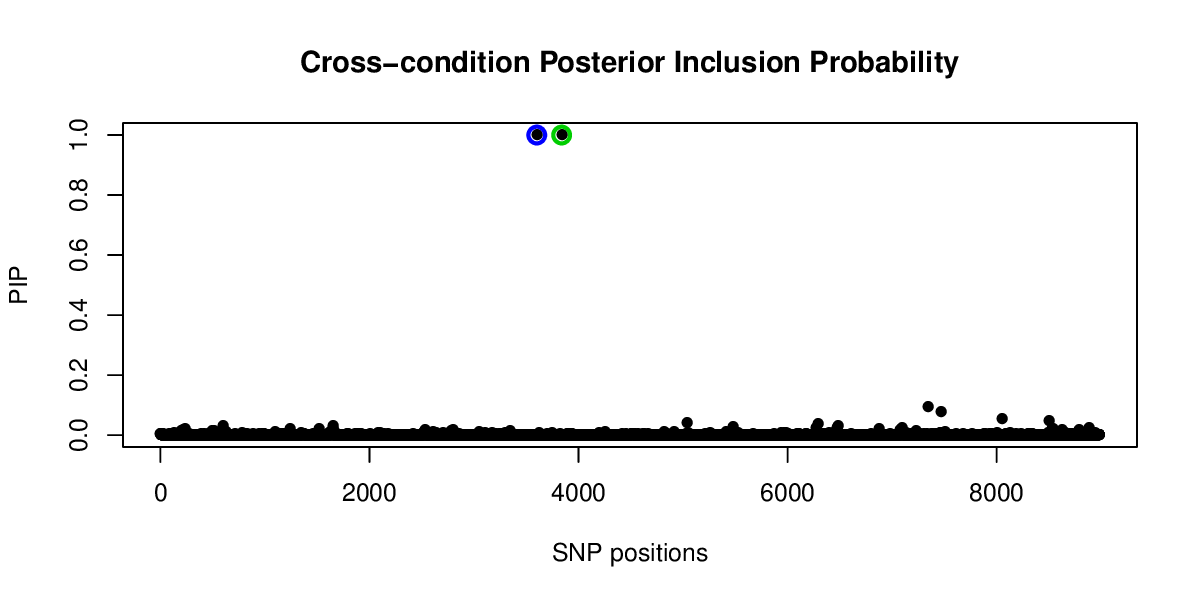

In [47]:
%preview susie_plot_toy.pdf -s png --dpi 150

> mmbr_plot_toy.pdf (5.0 KiB):

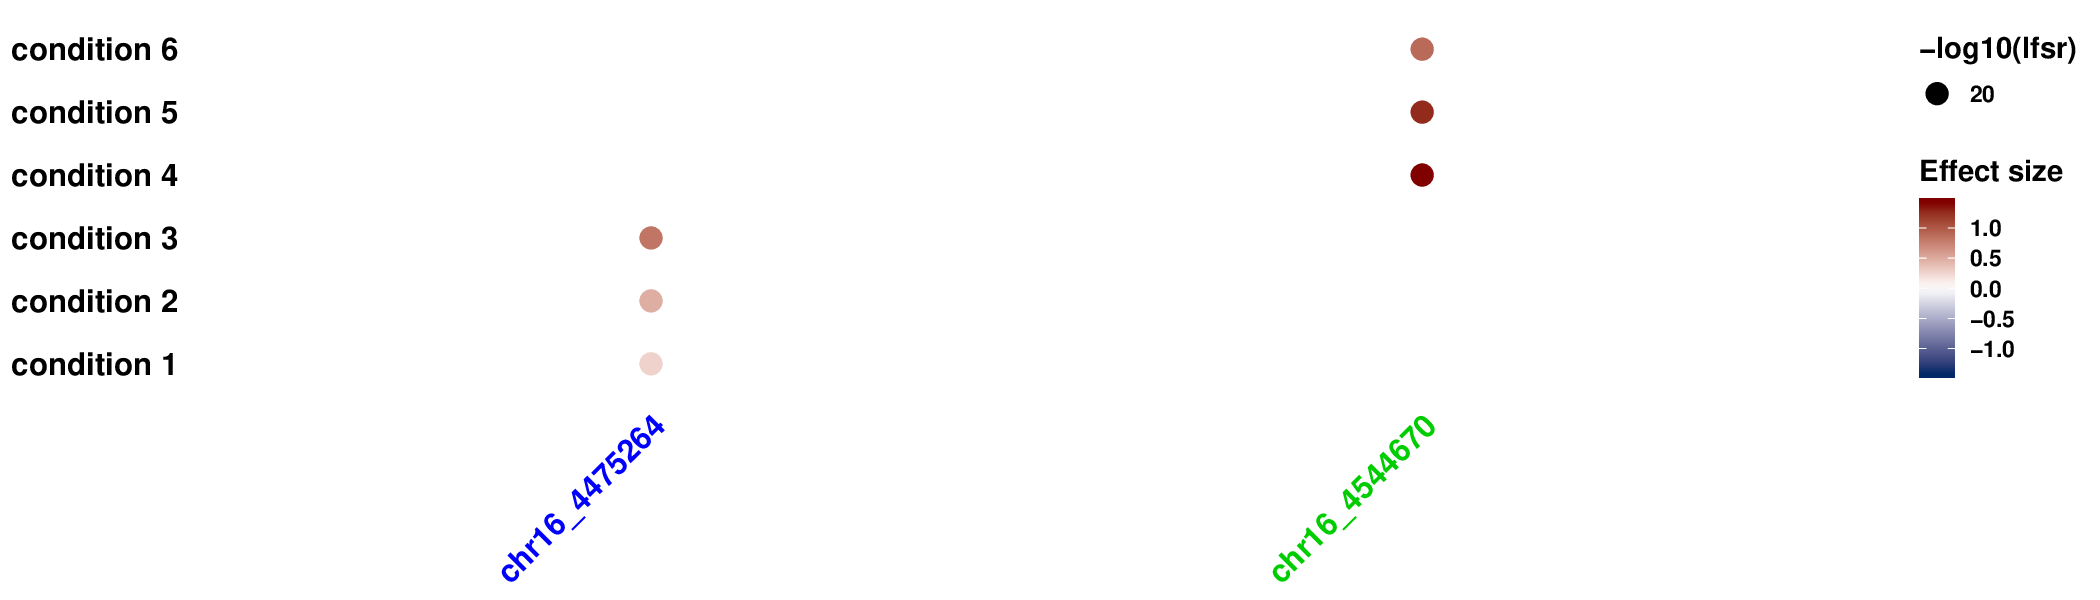

In [37]:
%preview mmbr_plot_toy.pdf -s png --dpi 150

For original effect size,

In [71]:
univariate_res = lapply(1:ncol(Y), function(i) susieR:::univariate_regression(genotype,Y[,i]))
res$bhat = do.call(cbind, lapply(1:ncol(Y), function(i) univariate_res[[i]]$betahat))
res$shat = do.call(cbind, lapply(1:ncol(Y), function(i) univariate_res[[i]]$sebetahat))

In [72]:
rownames(res$bhat) = snps
# colnames(res$bhat) = conditions
p = mmbr::mmbr_plot(res, original_sumstat = TRUE)

Suggested PDF canvas width: 15 height: 5.4 


In [73]:
pdf('mmbr_plot_toy_original.pdf', width = 14, height = 4.5)
print(p$plot)
dev.off()

png 
  2

> mmbr_plot_toy_original.pdf (8.6 KiB):

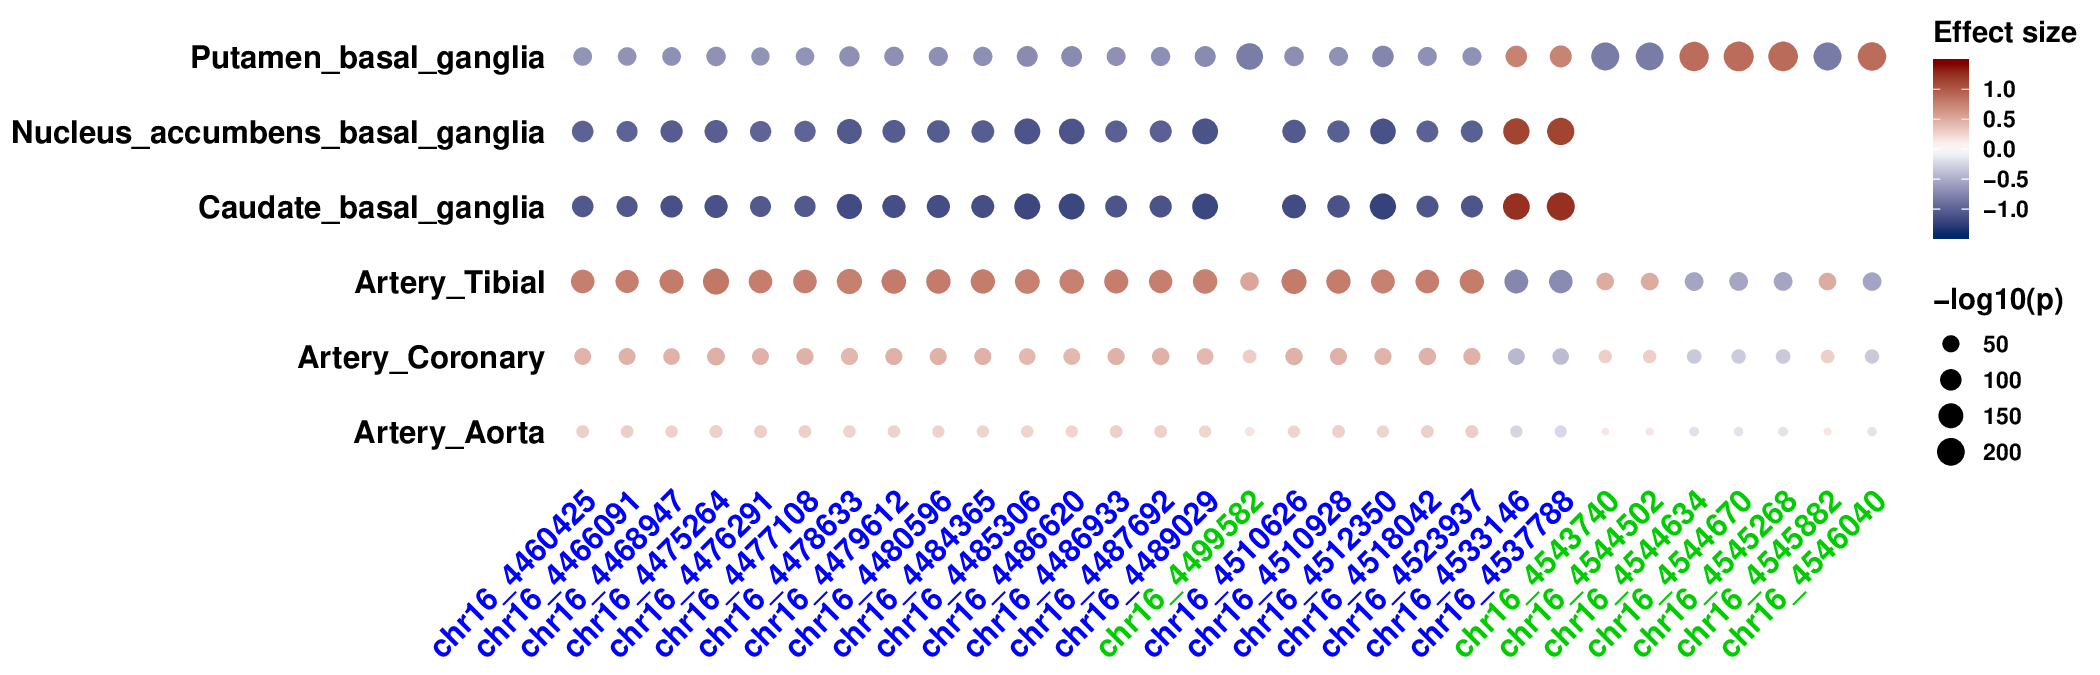

In [74]:
%preview mmbr_plot_toy_original.pdf -s png --dpi 150